In [ ]:
! wget https://s3.amazonaws.com/google-landmark/train/images_001.tar
! tar -xf images_001.tar

--2020-11-10 11:01:30--  https://s3.amazonaws.com/google-landmark/train/images_001.tar
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.50.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.50.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063727616 (1014M) [application/x-tar]
Saving to: ‘images_001.tar’

images_001.tar      100%[===================>]   1014M  33.9MB/s    in 28s     

2020-11-10 11:01:59 (36.5 MB/s) - ‘images_001.tar’ saved [1063727616/1063727616]



In [ ]:
from PIL import Image
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image,ImageCms
from skimage import io, color

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./0/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=8)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./0/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=8)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 8266 files belonging to 2 classes.
Using 6613 files for training.
Found 8266 files belonging to 2 classes.
Using 1653 files for validation.


In [ ]:
def preProc(A,y):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    B = normalization_layer(A)    
    A = tf.image.rgb_to_hsv(B)
    return A[:,:,:,-1:],A

Pro_train_ds = train_ds.map(preProc)
Pro_val_ds = val_ds.map(preProc)

Pro_train_ds

<MapDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

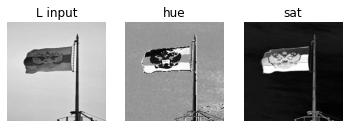

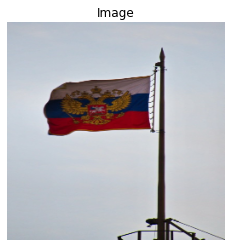

In [ ]:
A = next(iter(Pro_val_ds))
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
ax[0].imshow(A[0][5][:,:,0],cmap="gray")
ax[1].imshow(A[1][5][:,:,0],cmap="gray")
ax[2].imshow(A[1][5][:,:,1],cmap="gray")
ax[0].title.set_text("L input");ax[1].title.set_text("hue");ax[2].title.set_text("sat")
    
ax[0].axis(False);ax[1].axis(False);ax[2].axis(False);
plt.show()

plt.imshow(tf.image.hsv_to_rgb(A[1][5]))
plt.title("Image")
plt.axis(False)
plt.show()


In [ ]:
tf.keras.backend.clear_session()

ALP = 0.2

inputs = tf.keras.Input(shape=(256, 256,1))

x = layers.LeakyReLU(alpha=ALP)(inputs)
for i in [16,16,16]:
    x = layers.Conv2D(i, 3,padding="same")(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.MaxPool2D()(x) 

for i in [16,16,16]:
    x = layers.Conv2D(i, 3,padding = "same")(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

x = layers.Conv2D(2, 3,padding = "same",activation="sigmoid")(x)

outputs = layers.concatenate([x,inputs],axis=3)

model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(optimizer="rmsprop", loss="MAE")

H = model.fit(Pro_train_ds,epochs=60,verbose=2,validation_data=Pro_val_ds)


Epoch 1/60
827/827 - 54s - loss: 0.1266 - val_loss: 0.1227
Epoch 2/60
827/827 - 38s - loss: 0.1213 - val_loss: 0.1192
Epoch 3/60
827/827 - 38s - loss: 0.1200 - val_loss: 0.1180
Epoch 4/60
827/827 - 37s - loss: 0.1193 - val_loss: 0.1169
Epoch 5/60
827/827 - 38s - loss: 0.1189 - val_loss: 0.1167
Epoch 6/60
827/827 - 37s - loss: 0.1185 - val_loss: 0.1162
Epoch 7/60
827/827 - 38s - loss: 0.1183 - val_loss: 0.1159
Epoch 8/60
827/827 - 37s - loss: 0.1182 - val_loss: 0.1156
Epoch 9/60
827/827 - 38s - loss: 0.1178 - val_loss: 0.1153
Epoch 10/60
827/827 - 38s - loss: 0.1177 - val_loss: 0.1151
Epoch 11/60
827/827 - 38s - loss: 0.1175 - val_loss: 0.1150
Epoch 12/60
827/827 - 37s - loss: 0.1174 - val_loss: 0.1149
Epoch 13/60
827/827 - 38s - loss: 0.1173 - val_loss: 0.1148
Epoch 14/60
827/827 - 37s - loss: 0.1171 - val_loss: 0.1147
Epoch 15/60
827/827 - 37s - loss: 0.1170 - val_loss: 0.1145
Epoch 16/60
827/827 - 37s - loss: 0.1169 - val_loss: 0.1144
Epoch 17/60
827/827 - 37s - loss: 0.1167 - val_lo

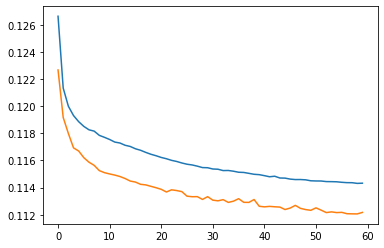

In [ ]:
plt.plot(H.history["loss"])
plt.plot(H.history["val_loss"])

In [ ]:
it = iter(Pro_val_ds)

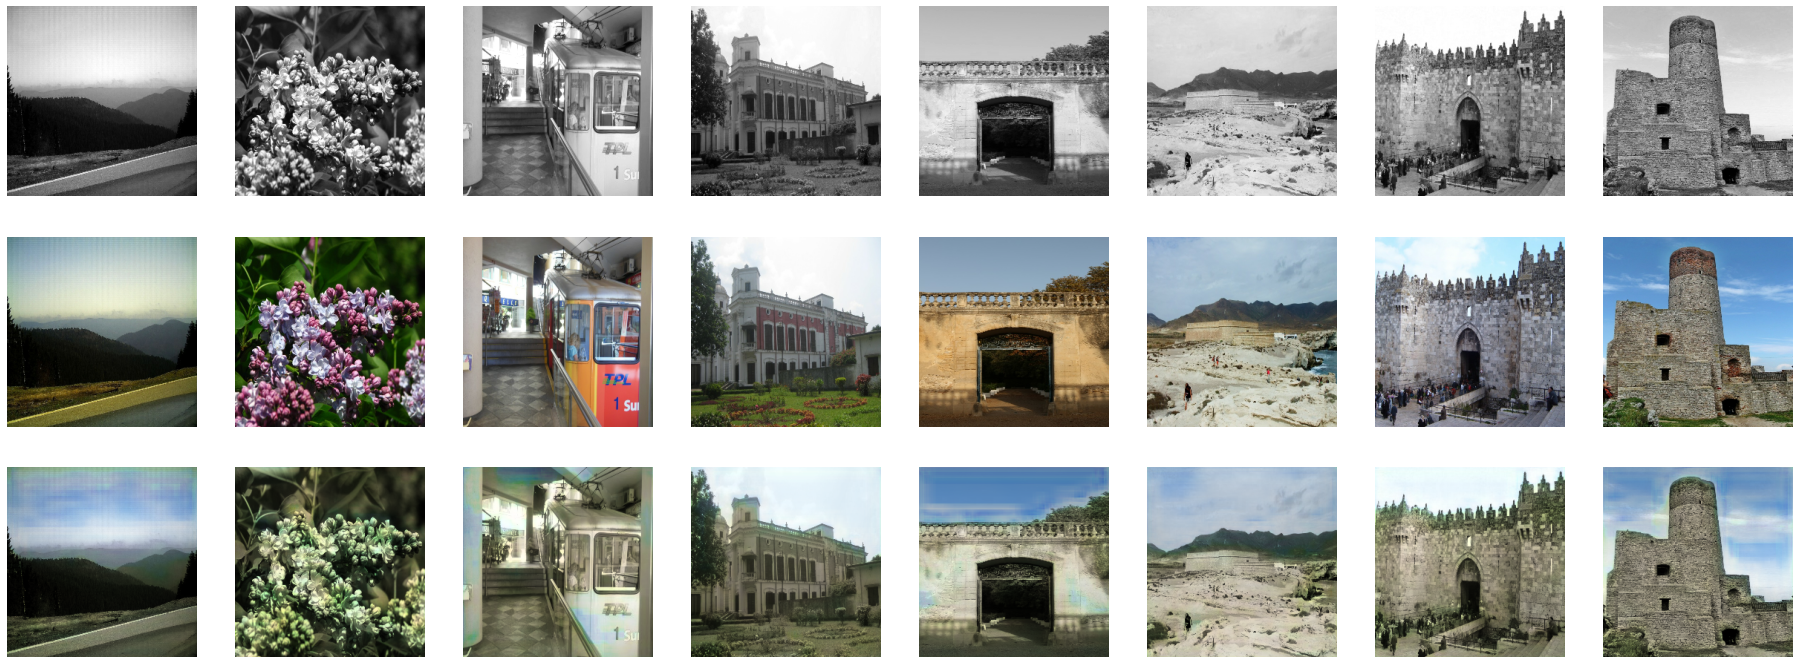

<Figure size 432x288 with 0 Axes>

In [ ]:
P = next(it)
#P = next(iter)(Pro_val_ds))

pred = model.predict(P)
fig,ax = plt.subplots(3,8,sharex=True,sharey=True,figsize = (8*4,3*4))
plt.figure()

for i in range(8):
    ax[2,i].imshow(tf.image.hsv_to_rgb(pred[i]))
    ax[0,i].imshow(P[0][i][:,:,0],cmap = "gray")
    ax[1,i].imshow(tf.image.hsv_to_rgb(P[1][i]))
    ax[0,i].axis(False);ax[1,i].axis(False);ax[2,i].axis(False)   


In [ ]:
model.save("Recolor")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Recolor/assets


In [ ]:
!zip -r /content/Recolor.zip /content/Recolor/

  adding: content/Recolor/ (stored 0%)
  adding: content/Recolor/saved_model.pb (deflated 91%)
  adding: content/Recolor/assets/ (stored 0%)
  adding: content/Recolor/variables/ (stored 0%)
  adding: content/Recolor/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/Recolor/variables/variables.index (deflated 71%)
